In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
pd.options.mode.copy_on_write=True
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf


sns.set_style('whitegrid')

# Downloading the data

We are interested in Apple stocks and stocks some other companies, here we use 'NVDA', 'MSFT', 'TSM', 'META', 'GOOG'.

In [46]:
tickers_list=['AAPL', 'NVDA', 'MSFT', 'TSM', 'META', 'GOOG',]
appl=yf.Ticker("AAPL")
nvda=yf.Ticker("NVDA")

tk_dict={}
for t in tickers_list:
    tk_dict[t]=yf.Ticker(t)

#getting data of year 2020-2022
train_df_dict={}
for t in tickers_list[1:]:
    train_df_dict[t]=tk_dict[t].history(start='2020-01-01', end='2022-12-31', interval="1d")[['Close']]

#getting data of 2023
test_df_dict={}
for t in tickers_list[1:]:
    test_df_dict[t]=tk_dict[t].history(start='2023-01-01', end='2023-12-31', interval="1d")[['Close']]


#for convenience, these are downloaded separately
stocks_apple_train=appl.history(start='2020-01-01', end='2022-12-31', interval="1d")
stocks_nvidia_train=nvda.history(start='2020-01-01', end='2022-12-31', interval="1d")
stocks_nvidia_test=nvda.history(start='2023-01-01', end='2023-12-31', interval="1d")

#apple data for 2023
#missing_indices for test year [29, 60, 95, 124, 159, 190, 219] 
apple_test=pd.read_csv('apple_2023_masked.csv', index_col=0)
apple_test.index=apple_test.index.astype('datetime64[ns, America/New_York]')
display(apple_test.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1day,2day,3day,4day,5day
Date,,,,,,,,,,,,
2023-01-03 00:00:00-05:00,129.215470,129.830399,123.155395,124.048042,112117500,0.0,0.0,124.048042,124.048042,124.048042,124.048042,124.048042
2023-01-04 00:00:00-05:00,125.853183,127.608724,124.057975,125.327515,89113600,0.0,0.0,125.327515,125.327515,125.327515,125.327515,125.327515
2023-01-05 00:00:00-05:00,126.091211,126.725981,123.740581,123.998451,80962700,0.0,0.0,123.998451,123.998451,123.998451,123.998451,123.998451
2023-01-06 00:00:00-05:00,124.980372,129.225391,123.869520,128.560867,87754700,0.0,0.0,128.560867,128.560867,128.560867,128.560867,128.560867
2023-01-09 00:00:00-05:00,129.403910,132.319889,128.828647,129.086517,70790800,0.0,0.0,129.086517,129.086517,129.086517,129.086517,129.086517


<Axes: xlabel='Date'>

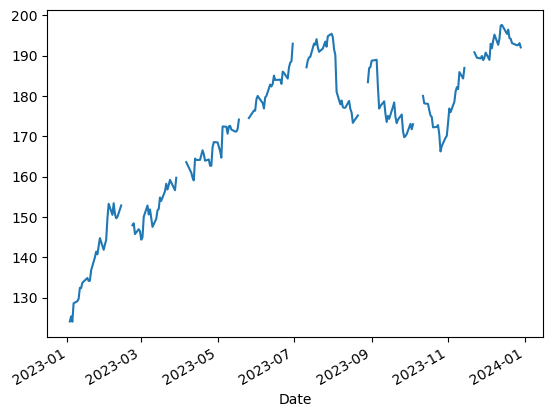

In [26]:
apple_test['5day'].plot()

In [47]:
#getting randomly the indices of the dates to remove from apple 2020-2022 stocks data
max_interval=5
intervals=[i for i in range(1,max_interval+1)]
n_rows=len(stocks_apple_train)
np.random.seed(150)
missing_indices=np.sort(np.random.randint(20, n_rows-20, size=30))
bins=np.digitize(missing_indices, bins=list(range(0, n_rows-max_interval+1, 25)))

curr_index=0
missing_indices_cleaned=[missing_indices[curr_index]]

for i,bin in enumerate(bins):
    if(bins[i]!=bins[curr_index]):
        curr_index=i
        missing_indices_cleaned.append(missing_indices[curr_index])


indices_to_mask= [np.ravel(np.array([list(range(i,i+interval)) for i in missing_indices_cleaned])) for interval in intervals]


# Autocorrelation, partial autocorrelation

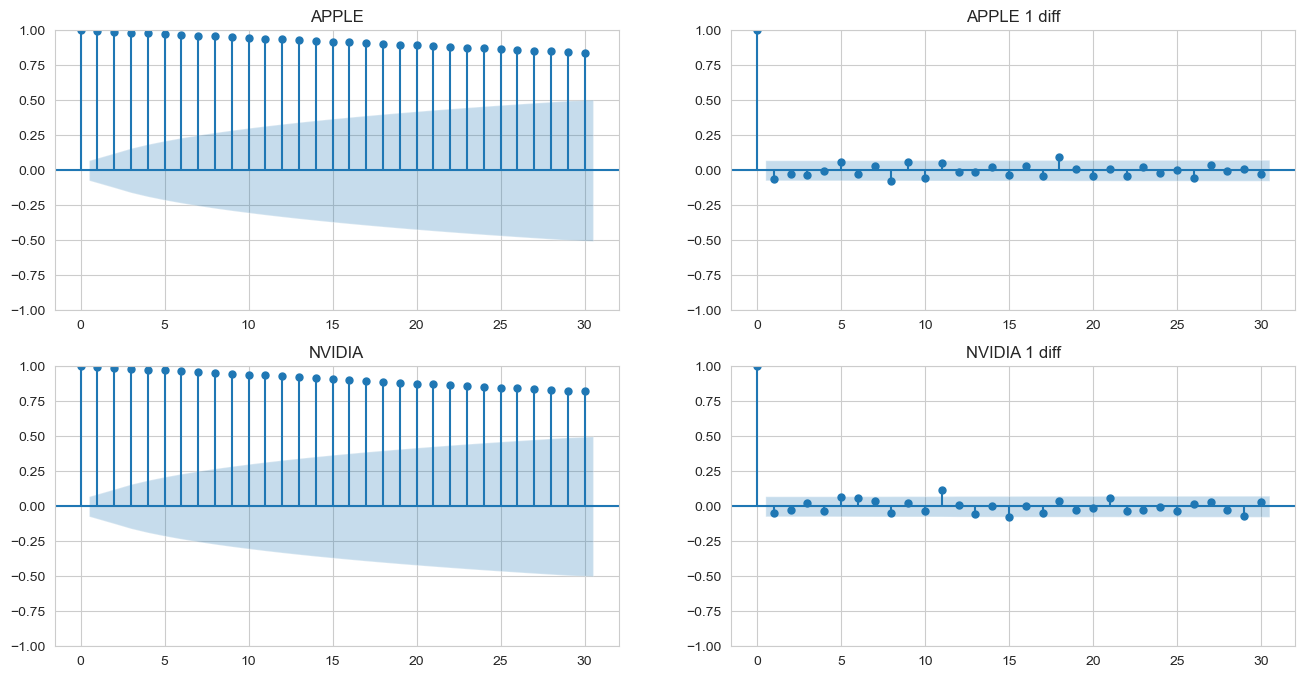

In [48]:
fig, axs=plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
sm.graphics.tsa.plot_acf(stocks_apple_train.Close.values, lags = 30, title='APPLE', ax=axs[0,0])
sm.graphics.tsa.plot_acf(stocks_apple_train.Close.diff().values[1:], lags = 30, title='APPLE 1 diff', ax=axs[0,1])
sm.graphics.tsa.plot_acf(stocks_nvidia_train.Close.values, lags = 30, title='NVIDIA', ax=axs[1,0])
sm.graphics.tsa.plot_acf(stocks_nvidia_train.Close.diff().values[1:], lags = 30, title='NVIDIA 1 diff', ax=axs[1,1])
plt.show()


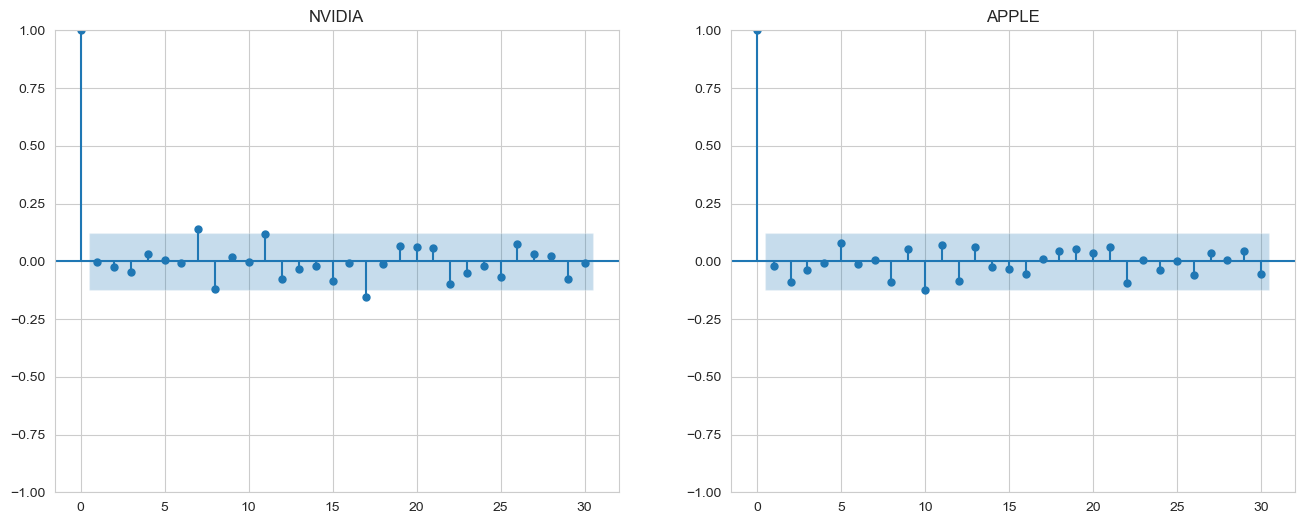

In [49]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs=plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sm.graphics.tsa.plot_pacf(stocks_nvidia_train.diff().Close.values[-252:], lags = 30, title='NVIDIA', ax=axs[0])
sm.graphics.tsa.plot_pacf(stocks_apple_train.diff().Close.values[-252:], lags = 30, title='APPLE', ax=axs[1])
plt.show()


# Comparing the data of Apple with other companies, data 2020-2022

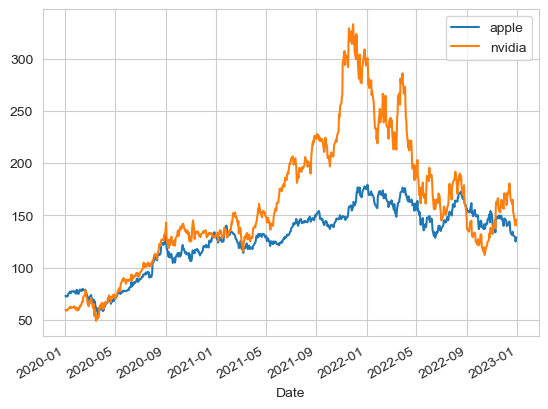

In [24]:
apple_close_train=stocks_apple_train[['Close']]
nvidia_close_train=stocks_nvidia_train[['Close']]

for i in range(max_interval):
    apple_close_train[f'{i+1}day']=apple_close_train.Close
    apple_close_train.iloc[indices_to_mask[i], i+1]=np.NaN


apple_close_train.Close.plot(label='apple')
nvidia_close_train.Close.plot(label='nvidia')
plt.legend()
plt.show()

# Daily return 

Formula for the daily return:
$$DR=\frac{X_t - X_{t-1}}{X_{t-1}}$$

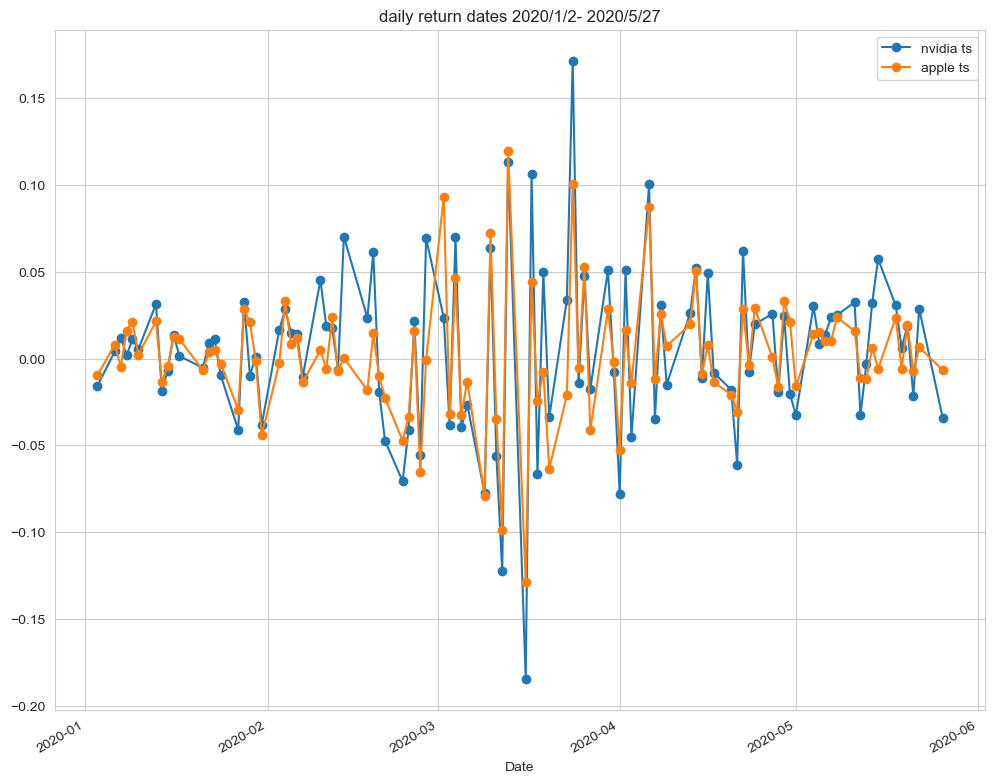

In [42]:
start=0
end=100
ind= [t for t in indices_to_mask[4] if t>=start and t<end]
fig, ax=plt.subplots(figsize=(12,10))
nvidia_close_train.pct_change(fill_method=None).Close[start:end].plot(label='nvidia ts', marker='o')
apple_close_train.pct_change(fill_method=None).Close[start:end].plot(label='apple ts', marker='o')
plt.title(f'daily return dates {nvidia_close_train.index[start].year}/{nvidia_close_train.index[start].month}/{nvidia_close_train.index[start].day}'+
                                     f'- {nvidia_close_train.index[end].year}/{nvidia_close_train.index[end].month}/{nvidia_close_train.index[end].day}')
ax.legend()
plt.show()

In the above plot we notice that, at least for these dates, the daily return movement of Apple closing prices are quite similar to NVIDIA's.

Let's plot the cross-correlations of the daily returns.

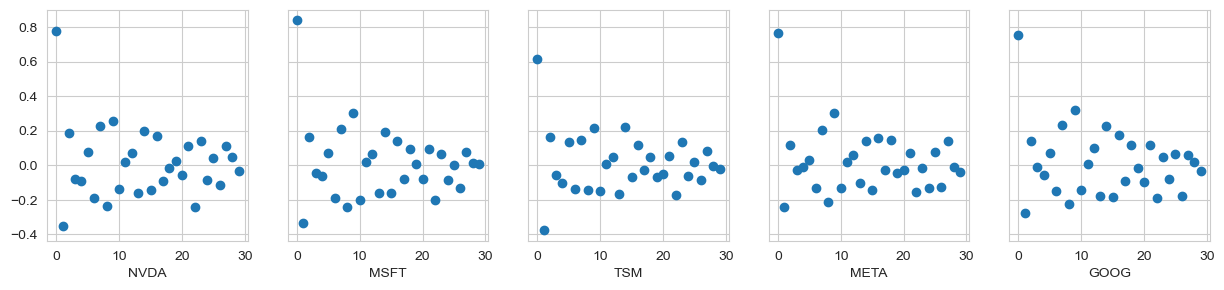

In [28]:
n_lags=30
fig, axs=plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=True)
for k,t in enumerate(tickers_list[1:]):
    crosscorr=ccf(train_df_dict[t].pct_change(fill_method=None)[:250].Close.dropna().values,stocks_apple_train.pct_change(fill_method=None)[:250].Close.dropna().values, nlags=n_lags)
    axs[k].scatter(x=[i for i in range(n_lags)], y=crosscorr)
    axs[k].set_xlabel(f'{t}')

Next we make the scatter plots of the daily return values of apple vs other companies.

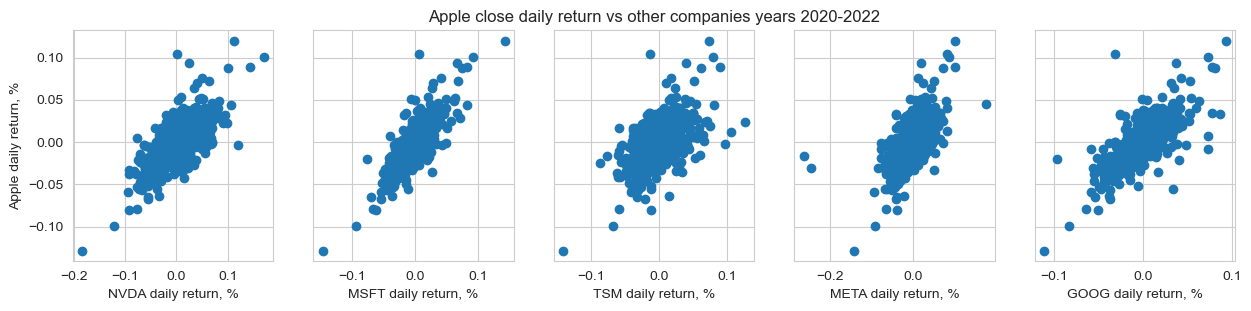

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True)
for i, (ax,t) in enumerate(zip(axes, tickers_list[1:])):
        ax.scatter(train_df_dict[t].Close.pct_change(fill_method=None), apple_close_train.Close.pct_change(fill_method=None))
        ax.set_xlabel(f'{t} daily return, %')

axes[0].set_ylabel('Apple daily return, %')
axes[2].set_title('Apple close daily return vs other companies years 2020-2022')
plt.show()

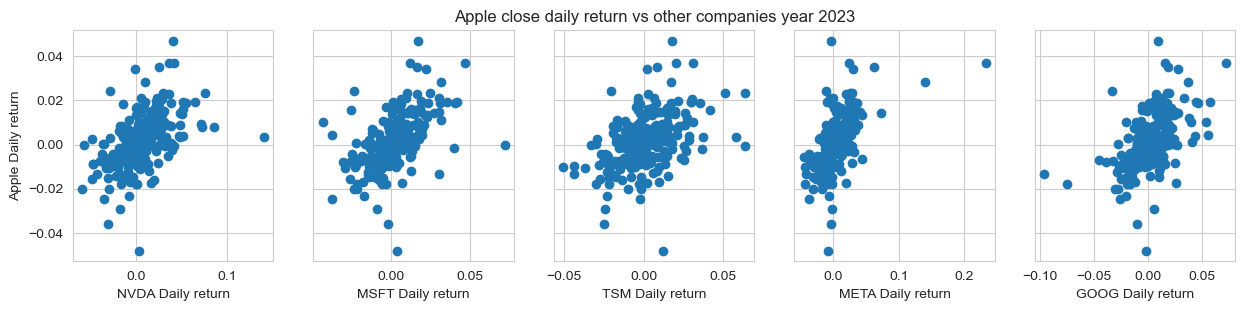

In [36]:

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,3), sharey=True)
for i, (ax,t) in enumerate(zip(axes, tickers_list[1:])):
        ax.scatter(test_df_dict[t].Close.pct_change(fill_method=None), apple_test['5day'].pct_change(fill_method=None))
        ax.set_xlabel(f'{t} Daily return')

axes[0].set_ylabel('Apple Daily return')
axes[2].set_title('Apple close daily return vs other companies year 2023')
plt.show()